# Decision Trees

Decision Trees are one of the oldest Supervised Learning Algorithms capable of performing both Classification and Regression tasks. It works by recursively splitting the data into smaller subsets with the aim of reducing impurity or variance in each segment within the subsets.

## Structure
Decision trees are structured like d-ary trees. All trees have a root node, internal nodes and leaf nodes. These leaf nodes in particular store the labels/outcomes for a particular subset of data.

Each node $S$ is split as: 
$$
S_{left} = \{X|X \leq t,X \in S\}, \quad
S_{right} = \{X|X > t,X \in S\}
$$
where $t$ is the threshold value of the split.
## Impurity Functions
Impurity functions are used in Decision Trees to calculate the impurity of the data within a particular subset, i.e. how mixed the data is in terms of target within the subset. These functions include:

### 1. Gini Impurity
For a leaf node, the Gini Impurity classifies the probablilty of misclassifying the data in the subset if it is labeled the same as the label value for the leaf node

$$
G(S) = \sum_{i=1}^c 1-p_i^2 
$$

### 2. Entropy
Entropy is a measure of randomness or uncertainty in the data.
$$
H(S) = \sum_{i=1}^c p_i \cdot log_2(p_i)
$$
Our goal for each case is to minimise entropy so that the probability of getting a particular $p_i \to 1$ while the rest $p_j \to 0$.
It is worth noting that these functions are concave from 0 to 1.
## Information Gain
It refers to the reduction in impurity caused by a split of the set. Suppose the set $S$ was split into 2 sets $S_l$ and $S_r$. Then,
$$
IG = I(S)-(\frac{|S_l|}{|S|} \ I(S_l) + \frac{|S_r|}{|S|} \ I(S_r))
$$
where $IG$ is the information gain, $I(K)$ is the impurity function for the set K, and $c$ represents number of classes. \
Our goal with the decision tree algorithm is to create nodes on the basis of **Maximising Information Gain**, which is effectively minimising the sum of Impurity functions of $S_l$ and $S_r$.

## Algorithm
#### 1. Setup
Input Dataset $\mathbf{X}$ with $m$ training examples and $n$ features, and target variables $\mathbf{y}$ of size $m$. Hence each set of features and its corresponding target variable can be represented as $(\mathbf{x^i},y^i)$.

#### 2. Find Optimal Split
Iterate through all features $j$ within the feature vector. Within the feature the possible thresholds are the unique values within the column for discrete values and the mean of every 2 adjacent datapoints for continuous values. \
For every possible threshold for each column, the optimal threshold value $t$ is the one which minimizes the computed sum of $I(S_l)$ and $I(S_r)$

#### 3. Creating the Decision Tree
If a best split is found, create a node with the values of $j$ and $t$. Recursively repeat the steps above until the stopping conditions below are satisfied.

#### 4. Stopping Conditions
1. Maximum Depth is reached.
2. Minimum number of nodes in the graph are reached.
3. The length of Set represented by a particular node is less than a particular value.
One or several conditions from the above can be chosen.

#### 5. Prediction
Once the tree is created, for any new test datapoint, start with the root node and check if the $j$ value of the datapoint is less than or equal to $t$ mentioned in the node. If so, recursively do the same for the left node, otherwise the right, until a leaf is reached, where the label of the leaf is returned.

## Implementation

### Importing Libraries and Data Visualization

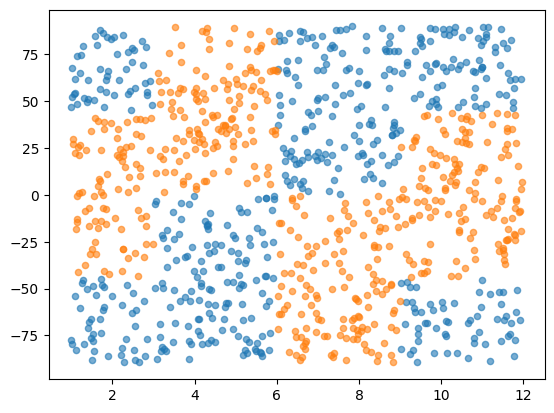

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv("DT_dataset.csv")

plt.figure()
for label, color in zip(data['Label'].unique(), ['blue', 'orange']):
    subset = data[data['Label'] == label]
    plt.scatter(subset['X1'], subset['X2'], label=f"Class {int(label)}", alpha=0.6, s=20)

### Implementation of Decision Tree

In [2]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, label=None):
        self.j = feature_index
        self.t = threshold
        self.l = left
        self.r = right
        self.label = label

class DecisionTree:
    def __init__(self, max_depth = 5):
        self.max_d = max_depth

    def gini(self, y):
        classes, counts = np.unique(y, return_counts=True)
        p = counts/len(y)
        return 1-np.sum(p**2)

    def split(self,X,j,t):
        l_mask = X[:,j] <= t
        return l_mask, ~l_mask
    
    def best_split(self,X,y):
        best_j, best_t = None, None
        min_gini = float('inf')
        
        for j in range(X.shape[1]):
            possible_t = X[:,j]
            
            for t in possible_t:
                lm,rm = self.split(X,j,t)
                l, r = y[lm],y[rm]
                if len(l)==0 or len(r)==0:
                    continue
                
                g = (len(l)*self.gini(l) + len(r)*self.gini(r))/len(y)
                
                if g < min_gini:
                    min_gini =g
                    best_j = j
                    best_t = t
        return best_j, best_t

    def make_tree(self,X,y, curr_d=0):
        if len(np.unique(y)) == 1 or curr_d >= self.max_d or len(y) < 5:
            majority_class = np.bincount(y).argmax()
            return Node(label=majority_class)
            
        j,t = self.best_split(X,y)
        
        if j==None:
            majority_class = np.bincount(y).argmax()
            return Node(label=majority_class)
        
        lm,rm = self.split(X,j,t)
        l = self.make_tree(X[lm],y[lm],curr_d+1)
        r = self.make_tree(X[rm],y[rm],curr_d+1)
        return Node(j,t,l,r)

    def train(self, X, y):
        self.root = self.make_tree(X,y)
    
    def predict_single(self, x, node):
        if node.label is not None:
            return node.label
        if x[node.j] <= node.t:
            return self.predict_single(x,node.l)
        else:
            return self.predict_single(x,node.r)

    def predict(self, X_test):
        return np.array([self.predict_single(x, self.root) for x in X_test])
        
def plot_decision_boundary(X, y, model):
    plt.figure(figsize=(8,8))
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap= 'bwr')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='bwr')

### Training and Prediction

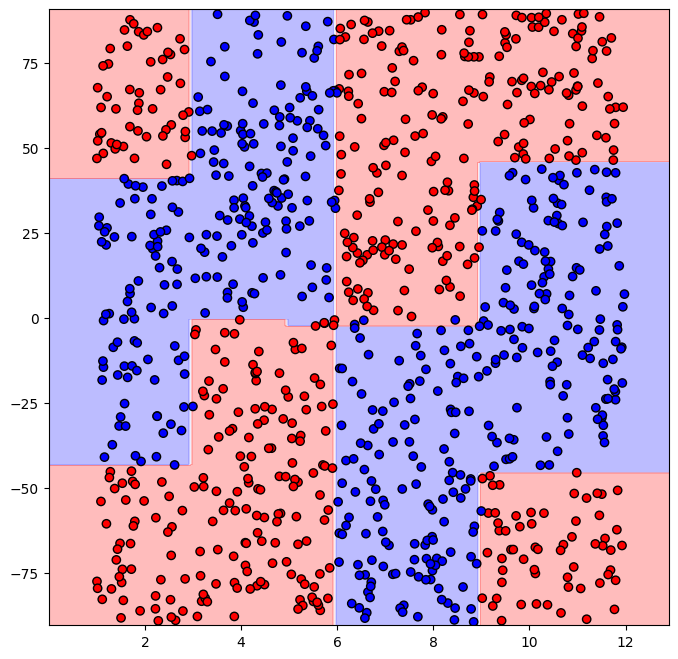

In [3]:
def main():
    data = pd.read_csv("DT_dataset.csv")
    X1 = data.iloc[:, :-1].to_numpy()
    y1 = data.iloc[:, -1].to_numpy()

    tree_model = DecisionTree(max_depth=7)
    tree_model.train(X1, y1)
    plot_decision_boundary(X1, y1, tree_model)

if __name__=="__main__":
    main()